In [1]:
"""
WORKING File
"""

'\nWORKING File\n'

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
%matplotlib inline

/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# function to perform stepwsise selection
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [4]:
"""
Function to plot y vs. a chosen set of x variables: includes regression line
"""

def plot_relationship(data, y_vars, x_vars, height=4.5):
    grid = sns.PairGrid(data=data, y_vars=y_vars, x_vars=x_vars, height=height)
    grid.map(sns.regplot)

In [5]:
"""
Function to identify multi-collinearity
"""
def multi_collinearity(data_pred, percent_correlated=0.75):
    df = data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    
    # zip the variable name columns (named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))
    
    # set index to pairs
    df.set_index(['pairs'], inplace=True)
    
    # drop level columns
    df.drop(columns=['level_1', 'level_0'], inplace=True)
    
    # rename correlation column as cc rather than 0
    df.columns = ['cc']
    
    # drop duplicates
    df.drop_duplicates(inplace=True)
    
    return df[(df.cc > percent_correlated) & (df.cc < 1)]
    

In [6]:
# set style of graphs and visualizations
plt.style.use('ggplot')

In [7]:
# import raw dataset
raw_data = pd.read_csv('kc_house_data.csv')

# examine the raw dataset
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [8]:
# drop the id column as that won't be relevant
clean_data = raw_data.drop('id', axis=1)

In [9]:
# handle missing values
# waterfront
# yr_renovated
# view

# waterfront
clean_data['waterfront'].unique()

array([nan,  0.,  1.])

In [10]:
# set all nans to 0 as houses missing waterfront info likely are not waterfront
clean_data['waterfront'] = clean_data['waterfront'].fillna(value=0.)

In [11]:
# yr_renovated missing values
clean_data['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [12]:
# similar to waterfront, assume missing data are 0s - non-renos
clean_data['yr_renovated'] = clean_data['yr_renovated'].fillna(value=0.)

In [13]:
# view missing values
clean_data['view'].unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

In [14]:
# set missing values to 0 with the assumption that missing values have no views
clean_data['view'] = clean_data['view'].fillna(value=0.)

In [15]:
clean_data.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [16]:
# no more missing values, check for duplicates
clean_data.duplicated().sum()

0

In [17]:
# there are no duplicates - - handles strings and convert all colulmns 
# to appropriate type
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  float64
 8   view           21597 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [18]:
# only string columns are the date and sqft_basement
# evaluate sqft_basement
clean_data['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [19]:
# replace '?' with zero with assumption that these do not have basements
clean_data['sqft_basement'] = clean_data['sqft_basement'].replace(to_replace='?',
                                                                  value='0.0')

# convert to a number format
clean_data['sqft_basement'] = clean_data['sqft_basement'].astype('float64')

In [20]:
# handle date column - convert to datetime and then split into year, month, day
clean_data['date'] = pd.to_datetime(clean_data['date'], 
                                    infer_datetime_format=True)

In [21]:
# create indidivual columns for year, month, day
clean_data['year_sold'] = clean_data['date'].map(lambda x: x.year)
clean_data['month_sold'] = clean_data['date'].map(lambda x: x.month)
clean_data['day_sold'] = clean_data['date'].map(lambda x: x.day)

# drop date column
clean_data = clean_data.drop('date', axis=1)

In [22]:
# start checking distributions / histograms
# clean_data.hist(figsize=(20, 15), bins='auto');

In [23]:
# price, sqft_above, sqft_living, sqft_living15 all appear continuous and log normally distributed
# the majority of houses seem to have less than 4 bathrooms
# most houses have a condition of 3 or higher
# the majority of houses have 2 floors or less
# there are a large number of houses with 0 sqft_basement, likely a result of not having a basement

In [24]:
# evaluate relationships with price
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['floors', 'waterfront', 'view', 'condition'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['grade', 'sqft_above', 'sqft_basement', 'yr_built'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['yr_renovated', 'zipcode', 'lat', 'long'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['sqft_living15', 'sqft_lot15'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['year_sold', 'month_sold', 'day_sold'])

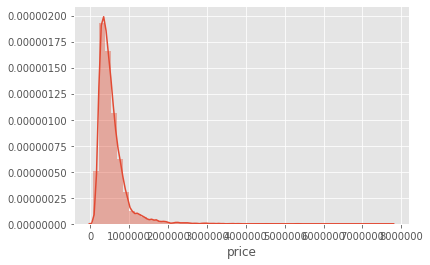

In [25]:
# there are a number of significant outliers impacting 
# look at just the distribution of price
sns.distplot(clean_data['price']);

In [26]:
# looks log normally distributed - - log transform after baseline model
# replot only continuous columns vs. price
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['yr_built', 'yr_renovated', 'zipcode', 'lat'])
# plot_relationship(data=clean_data, y_vars=['price'], x_vars=['long', 'sqft_living15', 'sqft_lot15'])

In [27]:
# drop non-linear
preprocessed = clean_data.drop(['sqft_lot', 'yr_built', 'yr_renovated',
                                'zipcode', 'lat', 'long', 'sqft_lot15'], axis=1)

In [28]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   floors         21597 non-null  float64
 5   waterfront     21597 non-null  float64
 6   view           21597 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  float64
 11  sqft_living15  21597 non-null  int64  
 12  year_sold      21597 non-null  int64  
 13  month_sold     21597 non-null  int64  
 14  day_sold       21597 non-null  int64  
dtypes: float64(6), int64(9)
memory usage: 2.5 MB


In [29]:
# we've now dropped non-linear
# identify and remove any multi-collinearity
data_pred = preprocessed.drop(['price'], axis=1)
correlated_predictors = multi_collinearity(data_pred, 0.75)
correlated_predictors

,cc
pairs,
"(sqft_above, sqft_living)",0.876448
"(month_sold, year_sold)",0.782325
"(sqft_living, grade)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(sqft_living, bathrooms)",0.755758


In [30]:
# We see the following relationships:
# sqft_above: sqft_living, grade
# sqft_living: sqft_above, grade, sqft_living15, bathrooms
# month_sold: year_sold
# drop sqft_above, grade, sqft_living15, bathrooms as correlated with sqft_living
# drop month_sold as correlated with year_sold
preprocessed.drop(['sqft_above', 'grade', 'sqft_living15', 'bathrooms', 'month_sold'],
                  axis=1, 
                  inplace=True)

In [31]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   sqft_living    21597 non-null  int64  
 3   floors         21597 non-null  float64
 4   waterfront     21597 non-null  float64
 5   view           21597 non-null  float64
 6   condition      21597 non-null  int64  
 7   sqft_basement  21597 non-null  float64
 8   year_sold      21597 non-null  int64  
 9   day_sold       21597 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 1.6 MB


In [32]:
# evaluate and handle categorical columns
# check for ordinal relationships and identify OHE where necessary

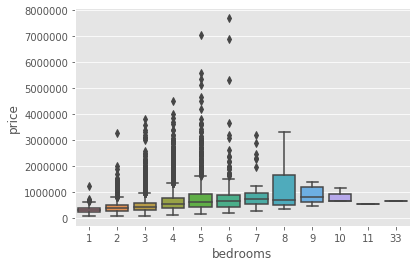

In [33]:
# bedrooms
sns.boxplot(x='bedrooms', y='price', data=preprocessed);

In [34]:
# pretty clear that there are a number of outliers, will leave in for baseline
# ordinal relationship, leave as a single column

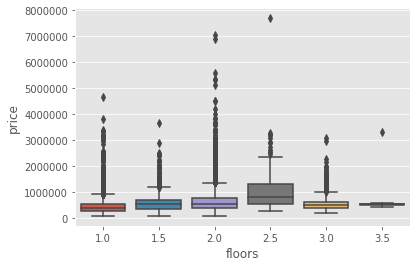

In [35]:
# floors
sns.boxplot(x='floors', y='price', data=preprocessed);

In [36]:
# no real ordinal relationship, will OHE
# scale by 10 to prevent issues with sms.ols later
preprocessed['floors_10'] = preprocessed['floors'] * 10

# convert to int
preprocessed['floors_10'] = preprocessed['floors_10'].astype('int64')

In [37]:
# add to ohe list
ohe_list = []
ohe_list.append('floors_10')

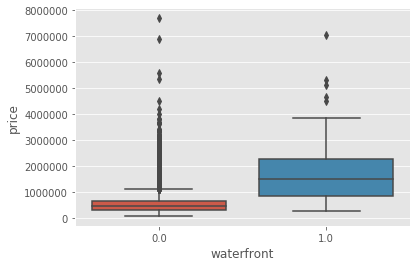

In [38]:
# waterfront
sns.boxplot(x='waterfront', y='price', data=preprocessed);

In [39]:
# looks like having a waterfront is positive relationship with price
# convert to int to avoid syntax issues
preprocessed['waterfront_clean'] = preprocessed['waterfront'].astype('int64')
ohe_list.append('waterfront_clean')

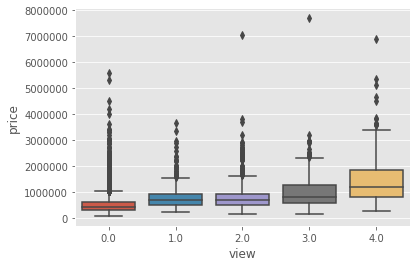

In [40]:
# view
sns.boxplot(x='view', y='price', data=preprocessed);

In [41]:
# slight ordinal relationship, leave as a single column

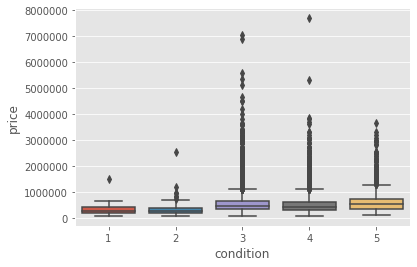

In [42]:
# condition
sns.boxplot(x='condition', y='price', data=preprocessed);

In [43]:
# no clear ordinal relationship here - - OHE for now
ohe_list.append('condition')

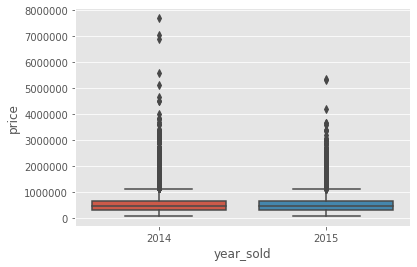

In [44]:
# year_sold
sns.boxplot(x='year_sold', y='price', data=preprocessed);

In [45]:
# ohe
ohe_list.append('year_sold')

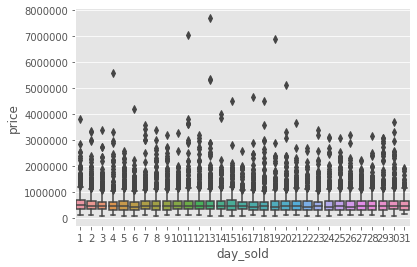

In [46]:
# days_sold
sns.boxplot(x='day_sold', y='price', data=preprocessed);

In [47]:
# create dummy variables
ohe_list.append('day_sold')
ohe_list

['floors_10', 'waterfront_clean', 'condition', 'year_sold', 'day_sold']

In [48]:
# create dummy variables
floors_dummies = pd.get_dummies(preprocessed['floors_10'], 
                                prefix='floors', 
                                drop_first=True)

waterfront_dummies = pd.get_dummies(preprocessed['waterfront_clean'], 
                                    prefix='waterfront', 
                                    drop_first=True)

condition_dummies = pd.get_dummies(preprocessed['condition'],
                                   prefix='condition',
                                   drop_first=True)

year_sold_dummies = pd.get_dummies(preprocessed['year_sold'],
                                   prefix='year_sold',
                                   drop_first=True)

day_sold_dummies = pd.get_dummies(preprocessed['day_sold'],
                                  prefix='day_sold',
                                  drop_first=True)

In [55]:
# drop columns
data_fin = preprocessed.drop(['floors', 'floors_10'], axis=1)
data_fin = data_fin.drop(['waterfront', 'waterfront_clean'], axis=1)
data_fin = data_fin.drop(['condition', 'year_sold', 'day_sold'], axis=1)

In [57]:
# concat with dummies
data_fin = pd.concat([data_fin, floors_dummies, 
                      waterfront_dummies, condition_dummies,
                      year_sold_dummies, day_sold_dummies], axis=1)

In [58]:
# run stepwise selection to select features
y = data_fin['price']
X = data_fin.drop('price', axis=1)
result = stepwise_selection(X, y, verbose=True)

/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  view                           with p-value 0.0
Add  bedrooms                       with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  waterfront_1                   with p-value 2.64729e-157
Add  condition_5                    with p-value 1.09556e-49
Add  floors_15                      with p-value 5.48961e-34
Add  floors_30                      with p-value 1.48558e-32
Add  floors_25                      with p-value 2.5305e-33
Add  condition_4                    with p-value 4.80982e-17
Add  year_sold_2015                 with p-value 1.16024e-10
Add  floors_35                      with p-value 0.0019816
Add  day_sold_13                    with p-value 0.00555331


In [59]:
result

['view',
 'bedrooms',
 'sqft_living',
 'waterfront_1',
 'condition_5',
 'floors_15',
 'floors_30',
 'floors_25',
 'condition_4',
 'year_sold_2015',
 'floors_35',
 'day_sold_13']

In [60]:
# run regression with these features
X = data_fin[result]
y = data_fin['price']
predictors = sm.add_constant(X)
model = sm.OLS(y, predictors).fit()

In [61]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     2427.
Date:                Tue, 23 Feb 2021   Prob (F-statistic):               0.00
Time:                        13:08:11   Log-Likelihood:            -2.9817e+05
No. Observations:               21597   AIC:                         5.964e+05
Df Residuals:                   21584   BIC:                         5.965e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.629e+04   6479.628      7.144      0.000    3.36e+04     5.9e+04
view            6.848e+04   2408.071     28.439      0.000    6.38e+04    7.32e+04
bedrooms       -4.949e+04   2191.245    -22.584      0.000   -5.38e+04   -4.52e+04
sqft_living      290.7063      2.316    125.495      0.000     286.166     295.247
waterfront_1     5.89e+05   2.15e+04     27.334      0.000    5.47e+05    6.31e+05
condition_5     9.737e+04   6235.425     15.615      0.000    8.51e+04     1.1e+05
floors_15       7.317e+04   5840.619     12.527      0.000    6.17e+04    8.46e+04
floors_30       1.292e+05   9947.638     12.988      0.000     1.1e+05    1.49e+05
floors_25         2.3e+05   1.91e+04     12.063      0.000    1.93e+05    2.67e+05
condition_4     3.277e+04   3825.378      8.566      0.000    2.53e+04    4.03e+04
year_sold_2015  2.216e+04   3497.586      6.336      0.000    1.53e+04     2.9e+04
floors_35       2.813e+05   9.06e+04      3.104      0.002    1.04e+05    4.59e+05
day_sold_13     2.489e+04   8974.583      2.773      0.006    7298.653    4.25e+04
==============================================================================
Omnibus:                    13246.755   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           459840.242
Skew:                           2.400   Prob(JB):                         0.00
Kurtosis:                      25.090   Cond. No.                     1.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~price
-------------------------------------------------------------------------------------


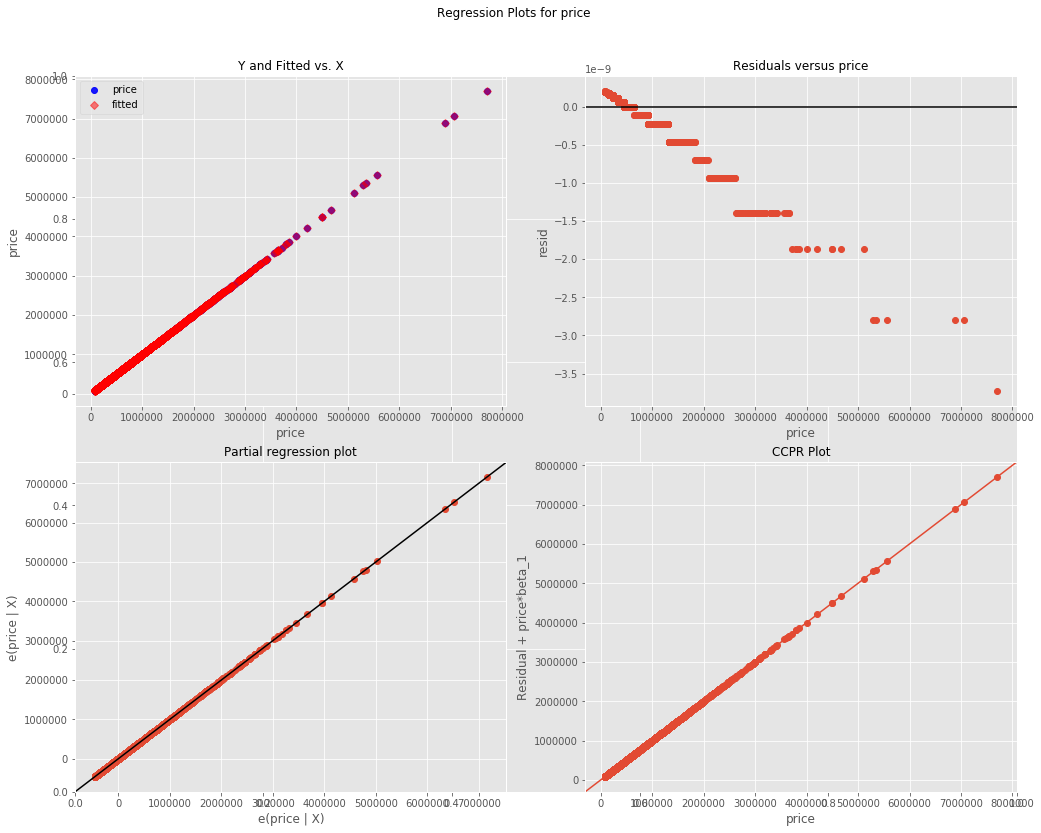

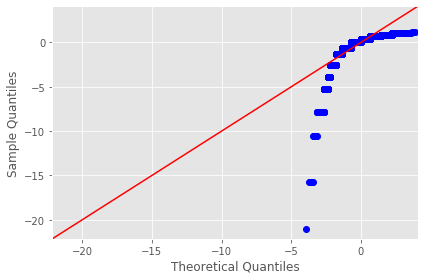

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~view
-------------------------------------------------------------------------------------


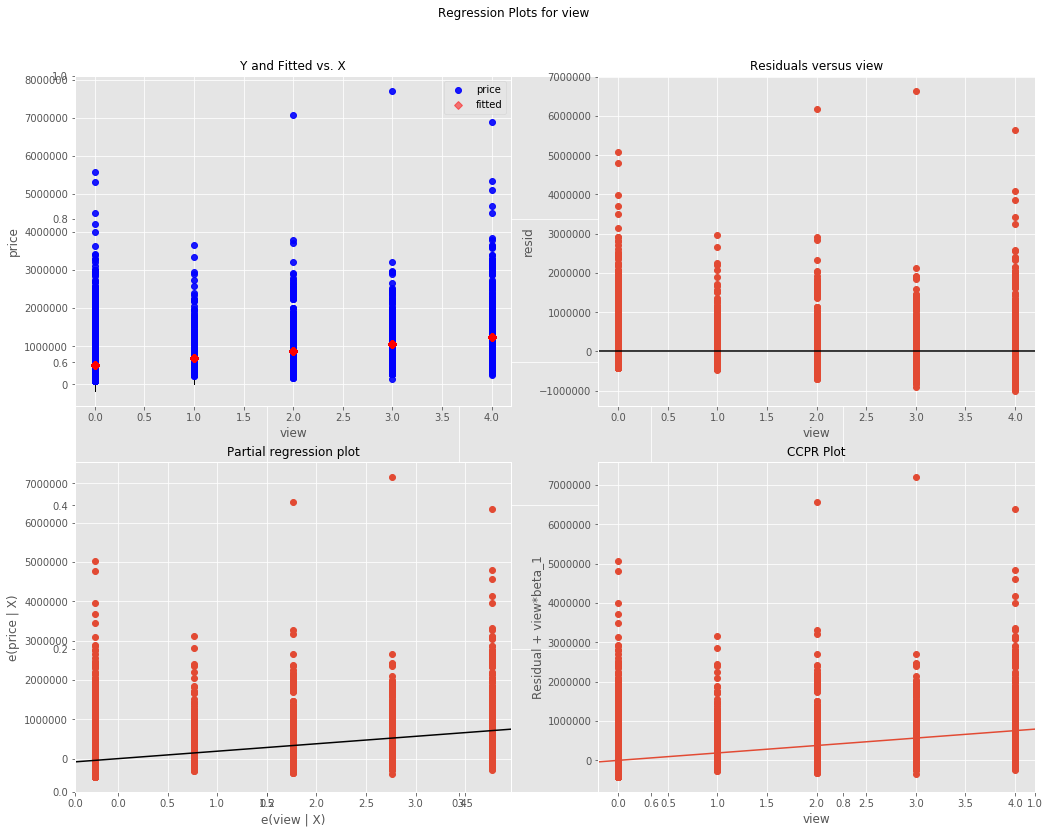

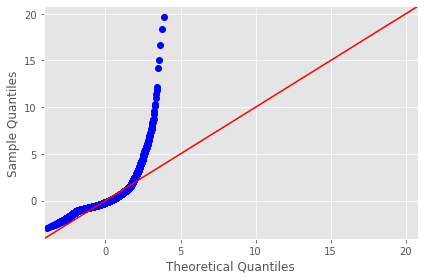

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~bedrooms
-------------------------------------------------------------------------------------


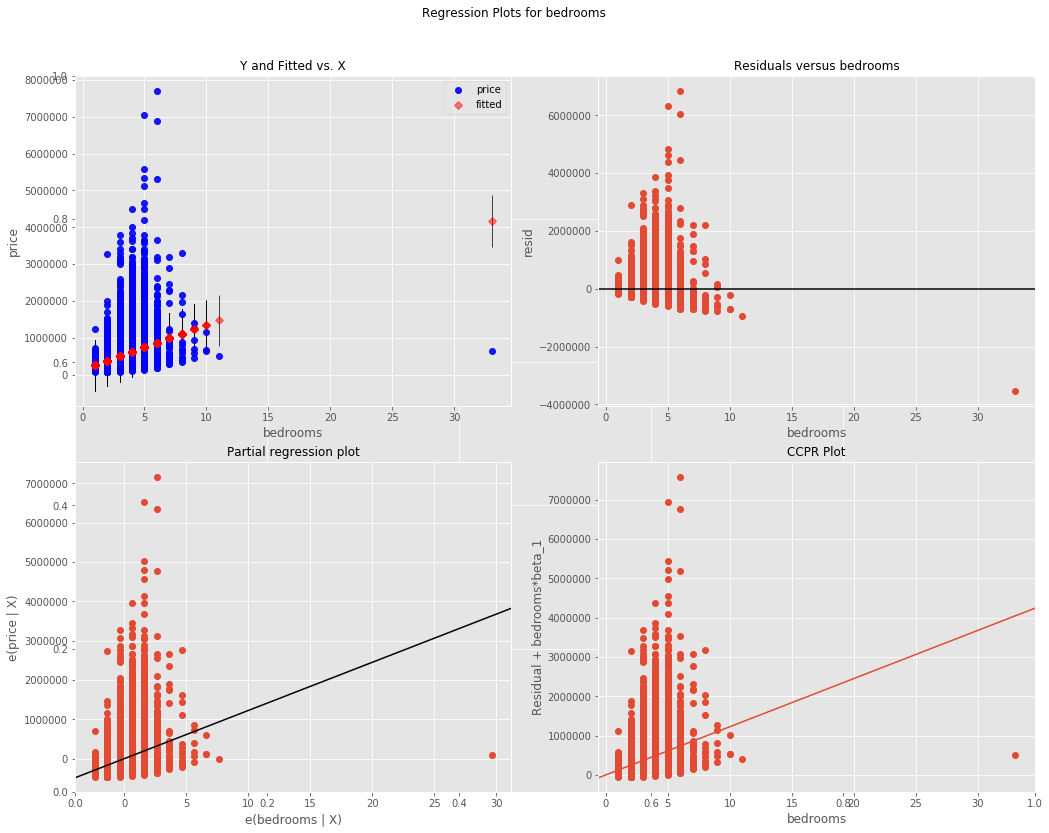

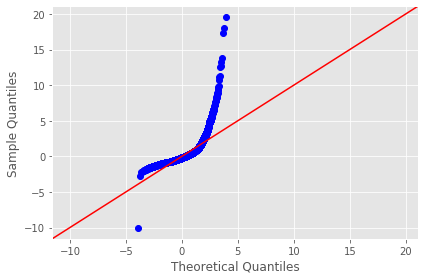

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~sqft_living
-------------------------------------------------------------------------------------


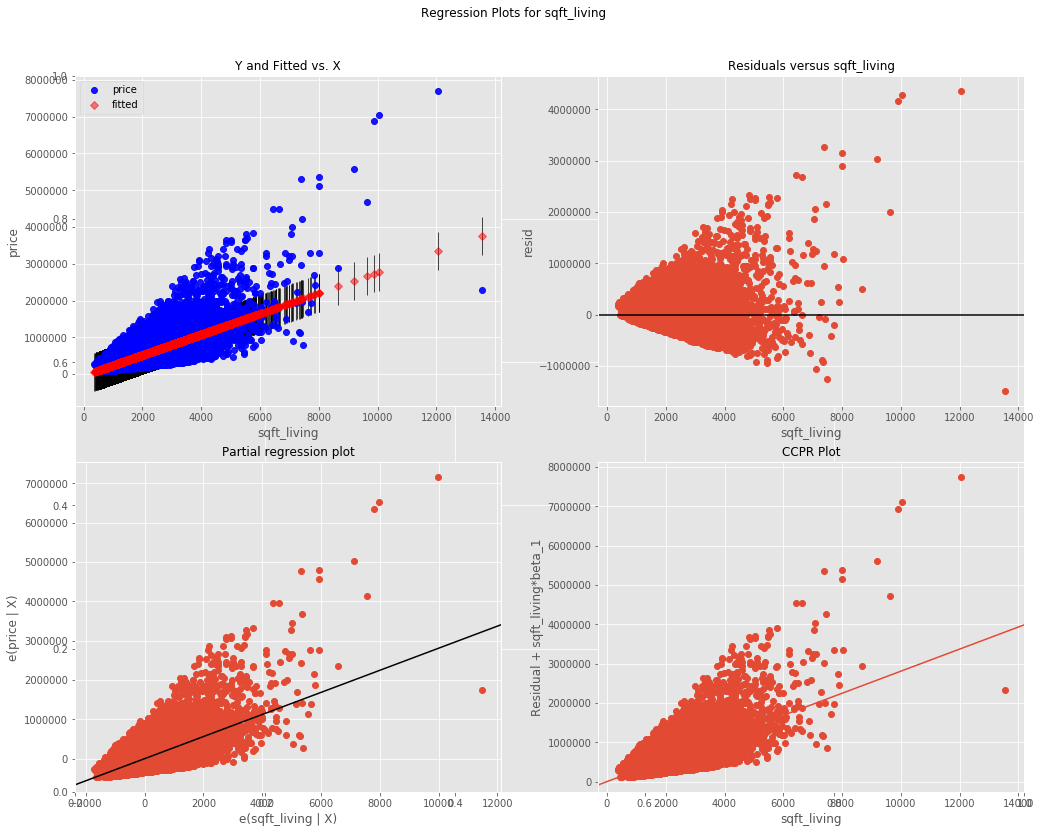

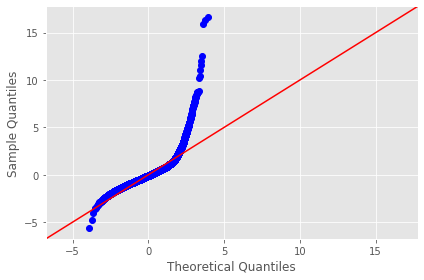

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~waterfront_1
-------------------------------------------------------------------------------------


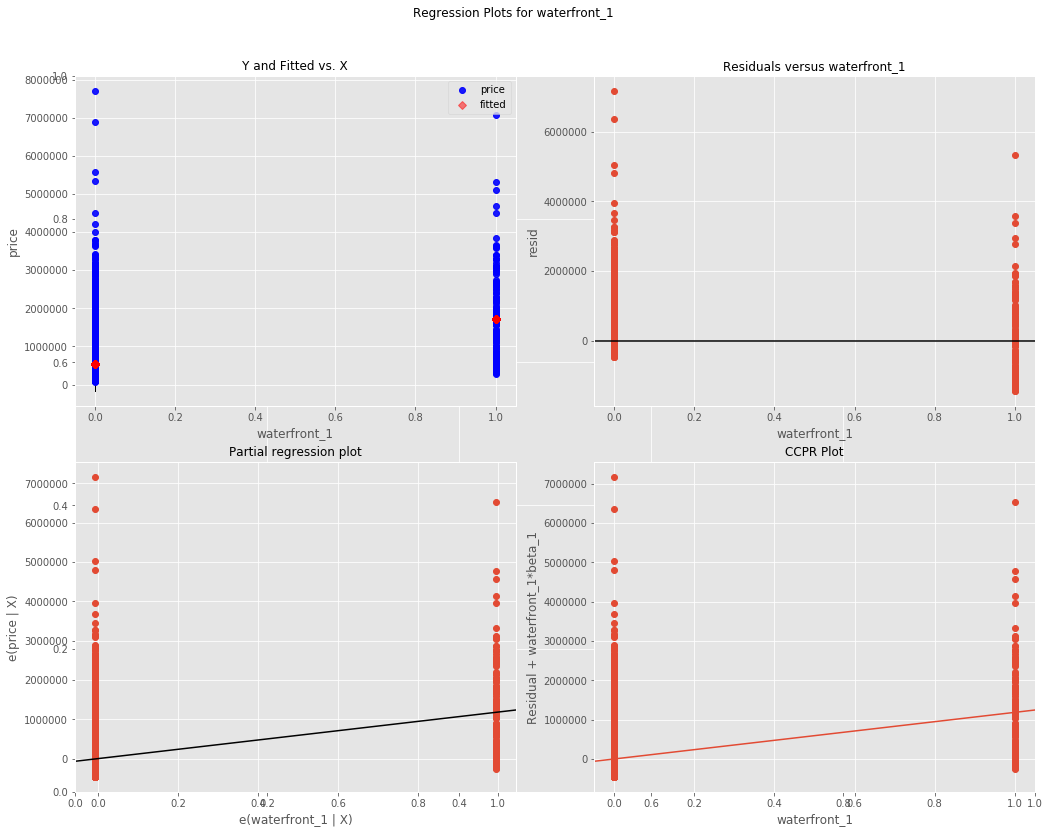

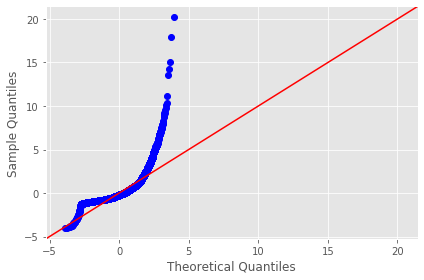

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_5
-------------------------------------------------------------------------------------


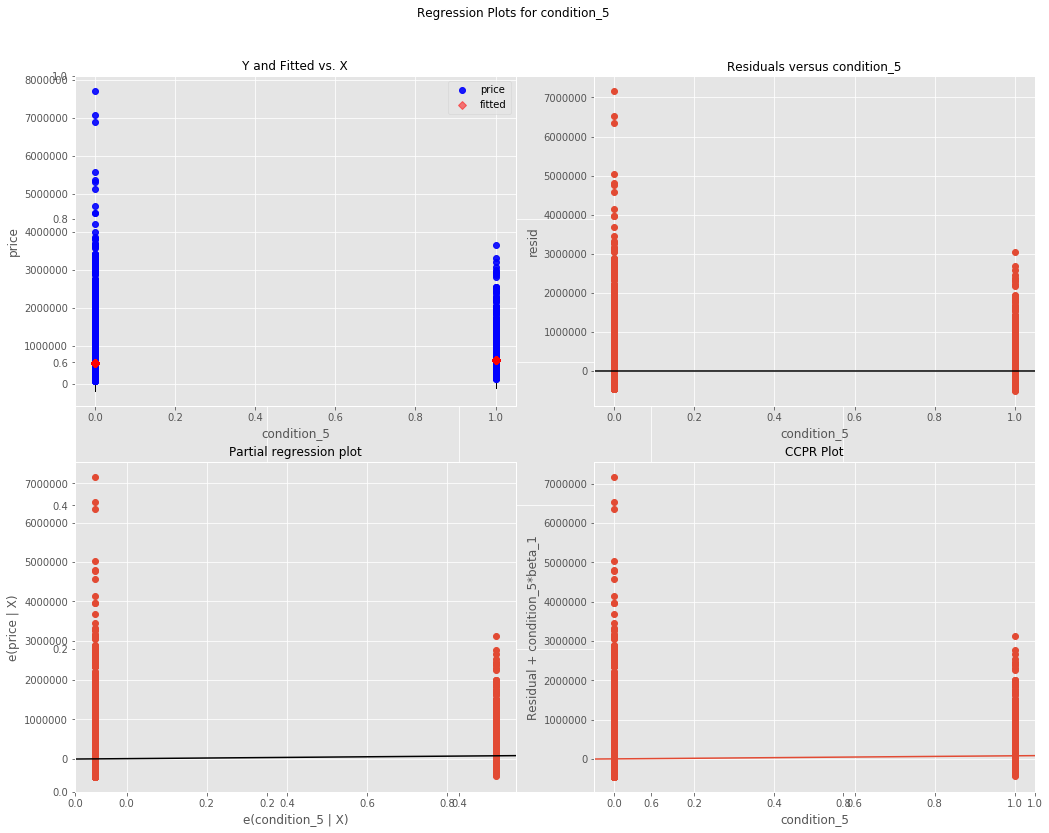

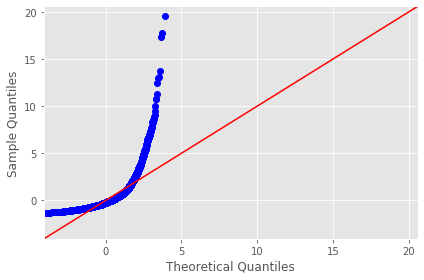

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_15
-------------------------------------------------------------------------------------


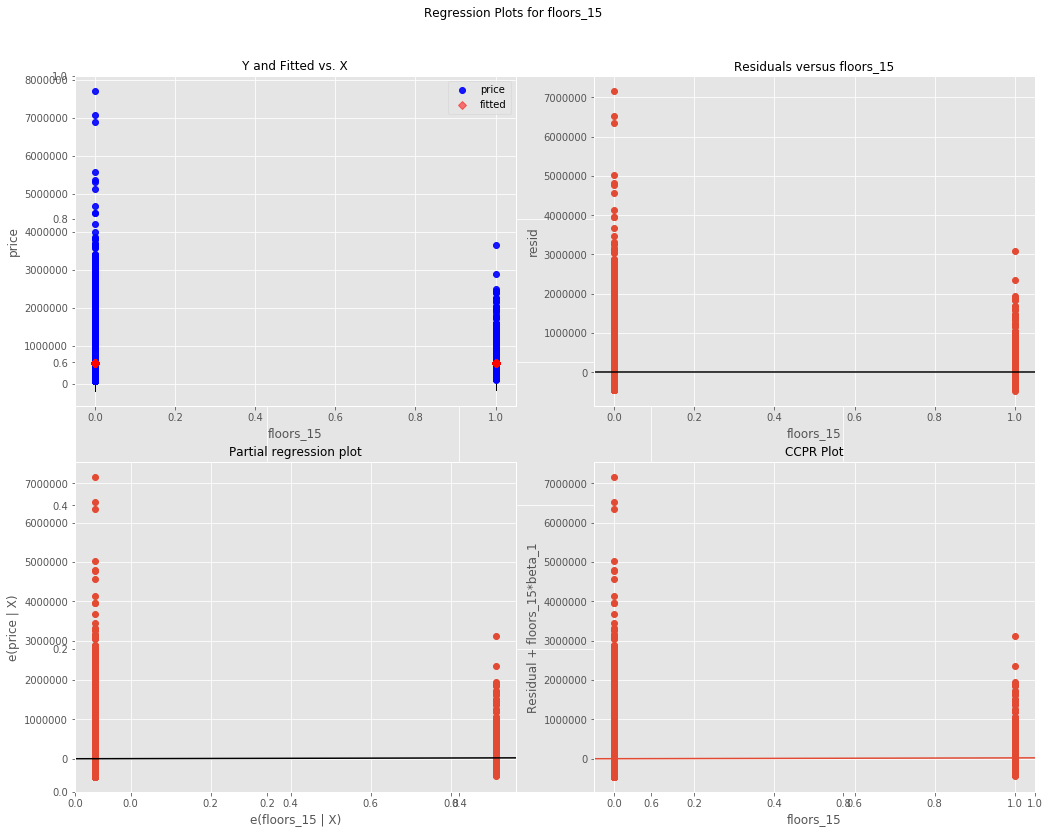

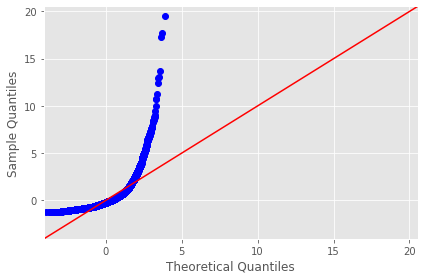

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_30
-------------------------------------------------------------------------------------


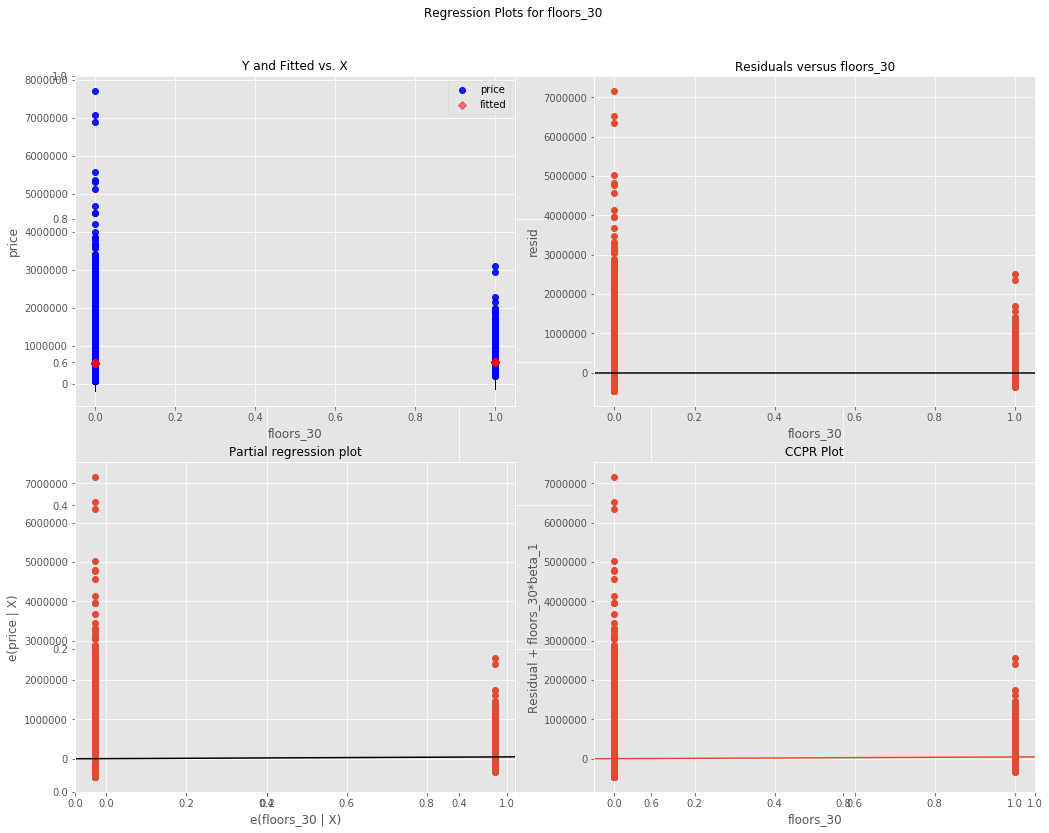

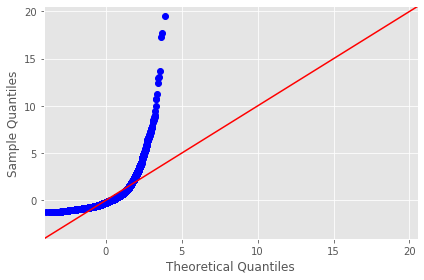

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_25
-------------------------------------------------------------------------------------


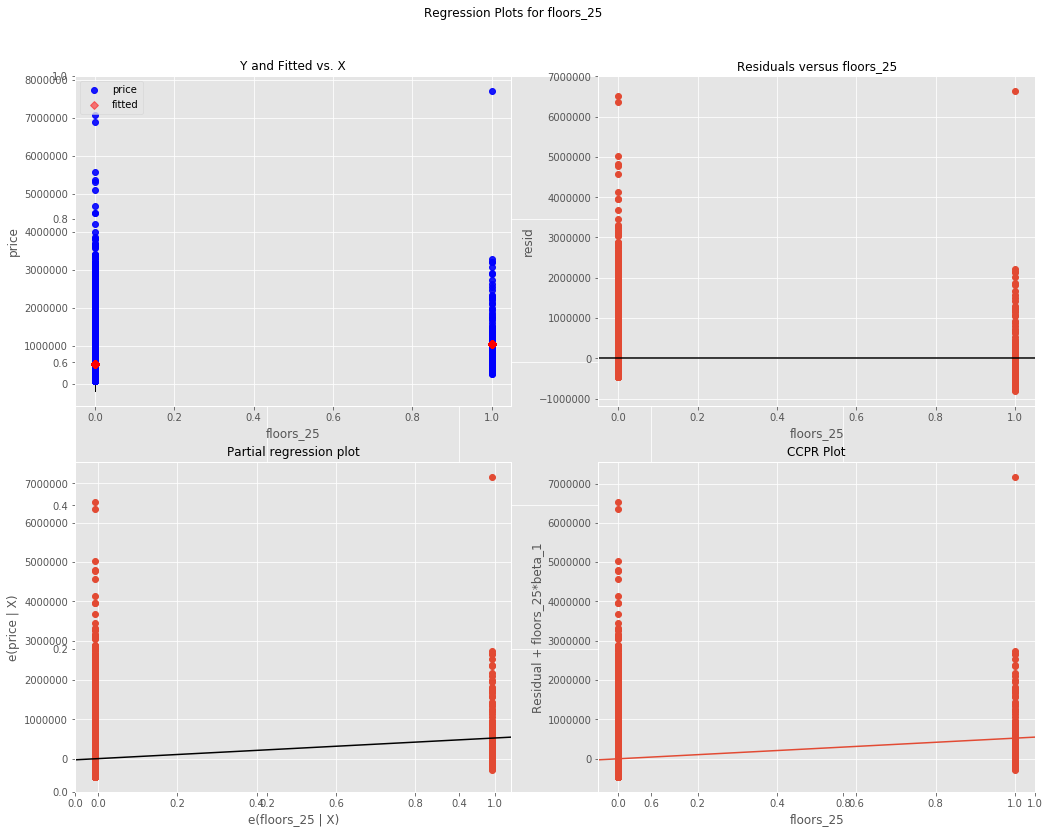

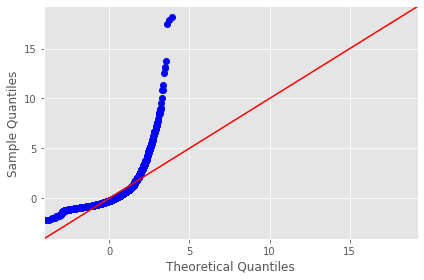

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~condition_4
-------------------------------------------------------------------------------------


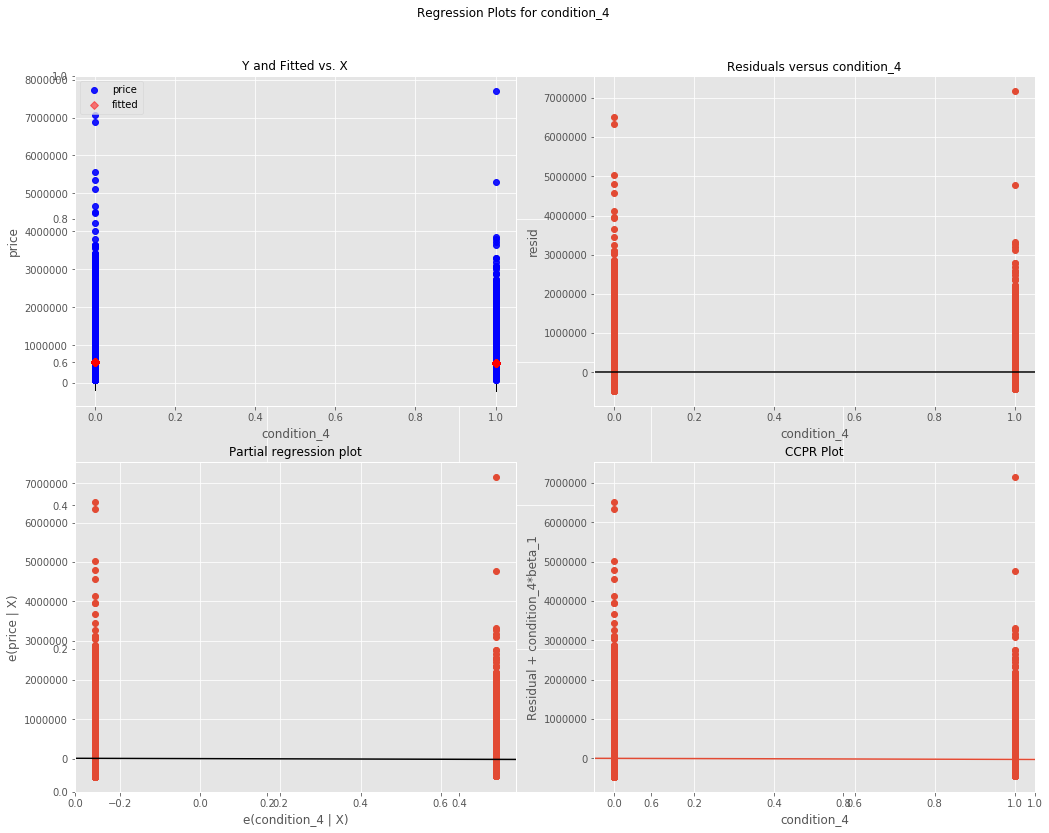

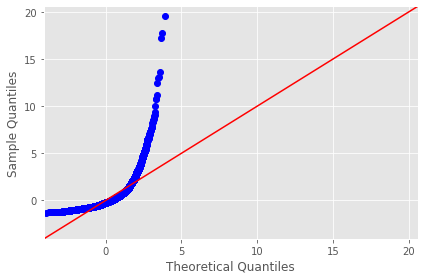

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~year_sold_2015
-------------------------------------------------------------------------------------


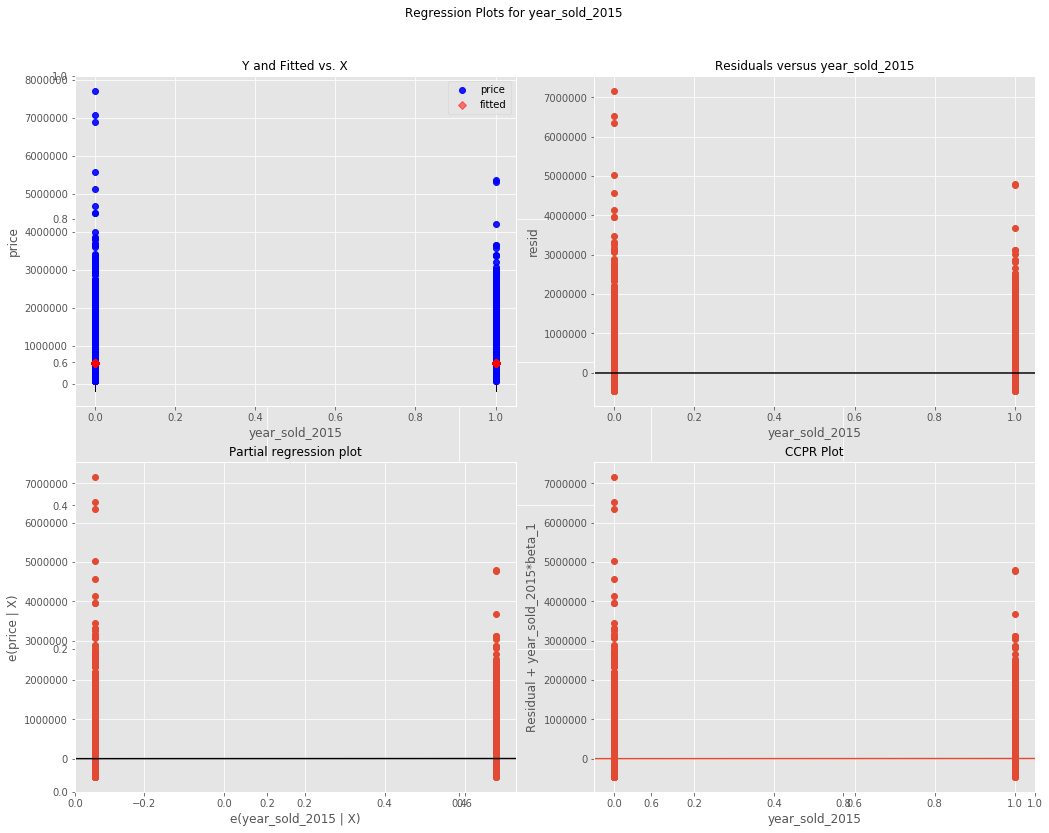

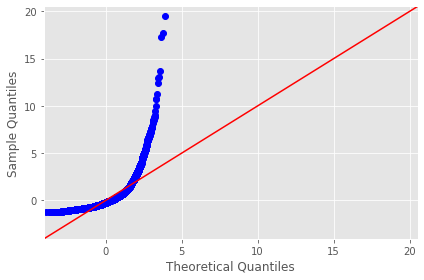

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~floors_35
-------------------------------------------------------------------------------------


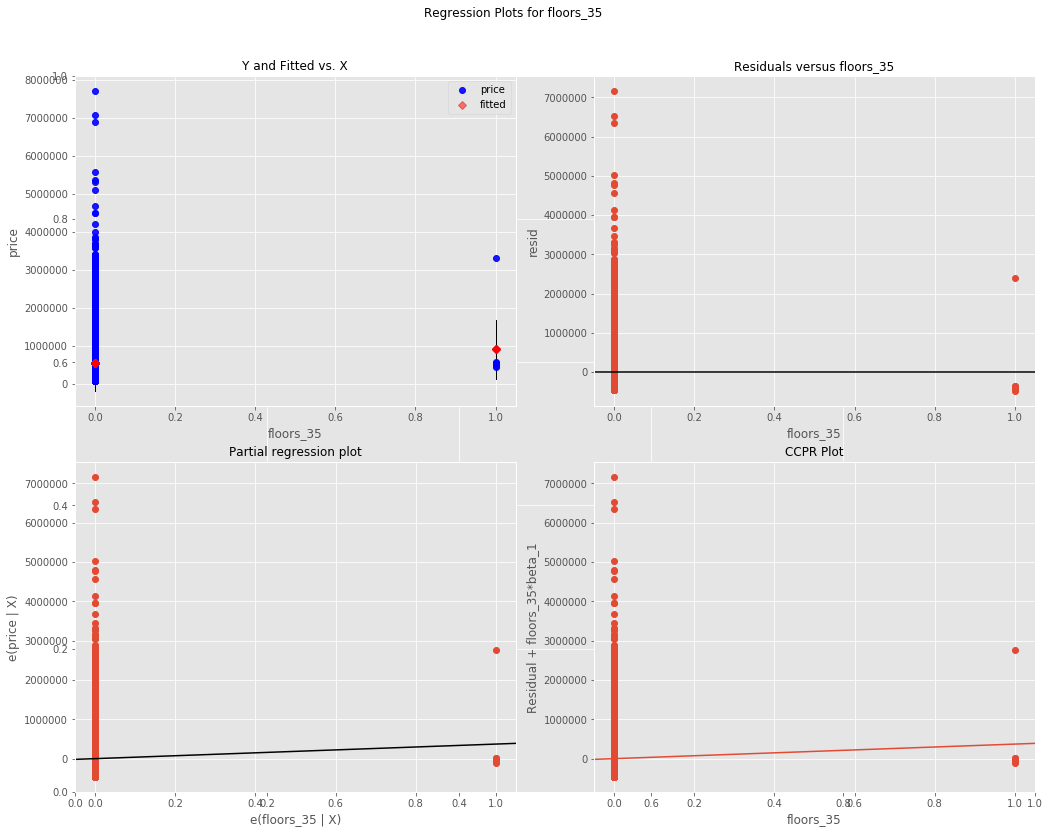

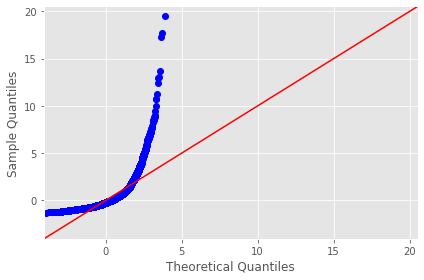

KC Housing DataSet - Regression Analysis and Diagnostics for log_price~day_sold_13
-------------------------------------------------------------------------------------


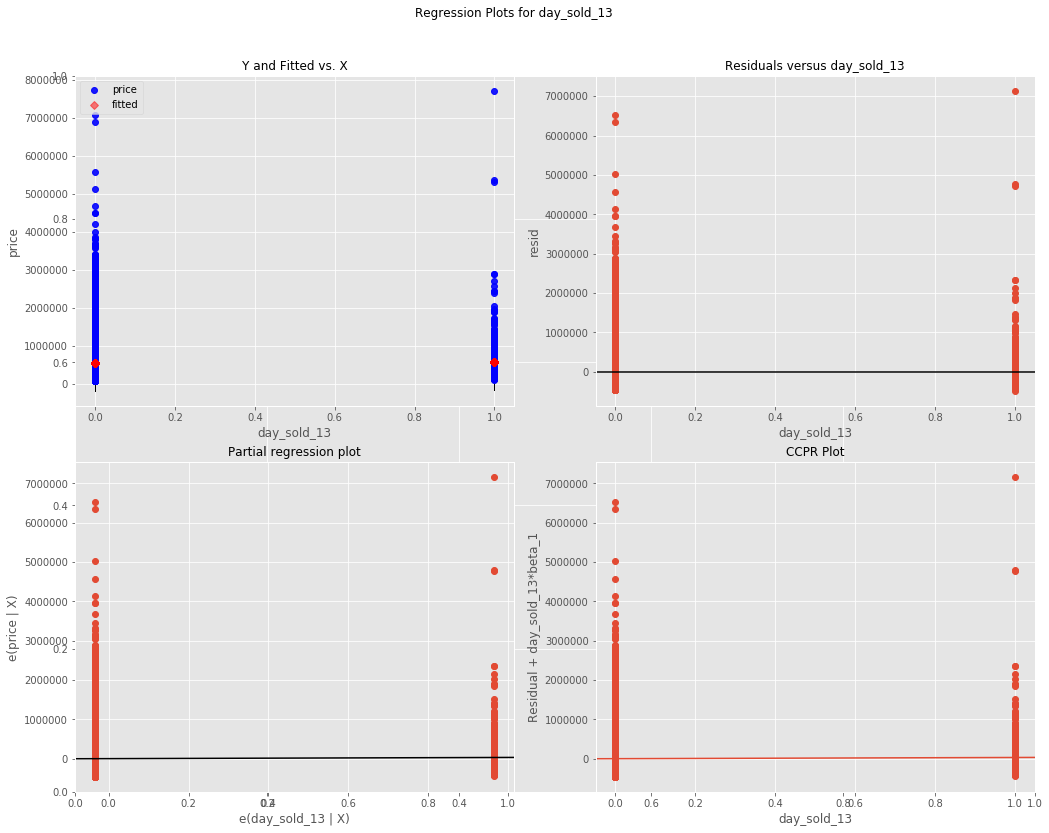

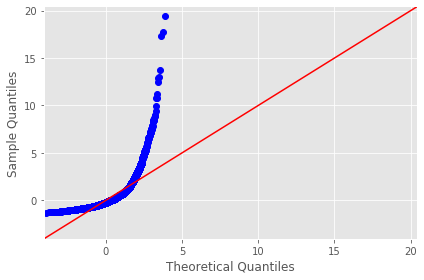

In [62]:
# evaluate residuals to check assumptions
dataset = pd.concat([y, X], axis=1)
results = []
y = 'price'
for idx, column in enumerate(dataset.columns):
    print (f"KC Housing DataSet - Regression Analysis and Diagnostics for log_price~{column}")
    print ("-------------------------------------------------------------------------------------")

    f = f'{y}~{column}'
    model = smf.ols(formula=f, data=dataset).fit()
    
    fig, axes = plt.subplots(figsize=(15,12))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.tight_layout()
    plt.show()
    
    results.append([column, model.rsquared, model.params[0], model.params[1], model.pvalues[1], sms.jarque_bera(model.resid)[0]])

In [64]:
# store results in dataframe to make future comparison easy
baseline_results = pd.DataFrame(results, columns=['ind_var', 
                                                  'r_squared', 
                                                  'intercept', 
                                                  'slope', 
                                                  'p-value', 
                                                  'normality (JB)'])

In [65]:
baseline_results

,ind_var,r_squared,intercept,slope,p-value,normality (JB)
0,price,1.000000,-2.310117e-10,1.000000e+00,0.000000e+00,1.801424e+06
1,view,0.154840,4.962148e+05,1.890458e+05,0.000000e+00,1.077904e+06
2,bedrooms,0.095350,1.271995e+05,1.224644e+05,0.000000e+00,1.195105e+06
3,sqft_living,0.492688,-4.398889e+04,2.808630e+02,0.000000e+00,5.426626e+05
4,waterfront_1,0.069858,5.322862e+05,1.184929e+06,0.000000e+00,9.097165e+05
5,condition_5,0.003310,5.341169e+05,7.846082e+04,2.645305e-17,1.147485e+06
6,floors_15,0.000253,5.384776e+05,2.056729e+04,1.948427e-02,1.135909e+06
7,floors_30,0.000401,5.390406e+05,4.439325e+04,3.233270e-03,1.134694e+06
8,floors_25,0.015091,5.363856e+05,5.246353e+05,2.182999e-73,1.056600e+06
9,condition_4,0.000946,5.470441e+05,-2.566967e+04,6.152950e-06,1.136385e+06


In [66]:
# q-q plots of baseline are looking terrible - - assumptions not close 
# to being met on normality of residuals - - further preprocess to try and improve results
# start with log-transforming price

In [67]:
# Model 2 #